In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
from numpy.typing import NDArray
from typing import List

In [3]:
img = cv2.imread('input/input.png')

In [4]:
def showImage(title : str, img):
    cv2.imshow(title, img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
equalized = clahe.apply( cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) )

In [6]:
# showImage('equalized',equalized)

In [7]:
def structuralFiltering(img : NDArray) -> NDArray:
    # r1 = cv2.morphologyEx(img, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    # R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5)), iterations = 1)
    # r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    # R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11)), iterations = 1)
    # r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    # R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (23,23)), iterations = 1)
    # f4 = cv2.subtract(R3, green)
    # f5 = clahe.apply(f4)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    tophat = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, kernel)
    return tophat

In [8]:
th = structuralFiltering(equalized)

In [9]:
showImage('th',th)

In [10]:
showImage('equalized',equalized)

In [17]:
hist,bins = np.histogram(equalized.ravel(),bins=256,range=[0,256])
print(f"len(hist)={len(hist)} len(bins)={len(bins)}")

len(hist)=256 len(bins)=257


len(hist)=255 len(bins)=256


Text(0, 0.5, 'Count')

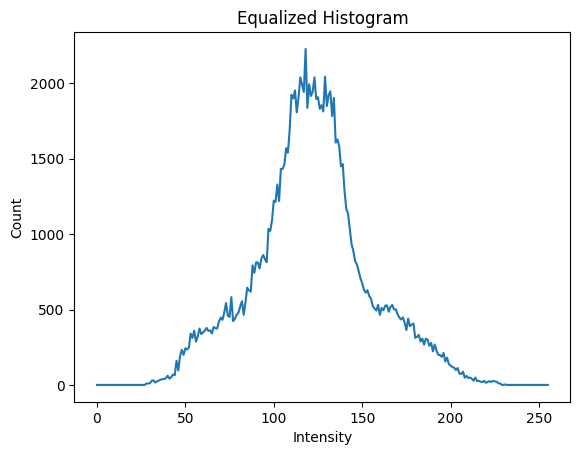

In [19]:
plt.plot(bins[:-1], hist)
plt.title('Equalized Histogram')
plt.xlabel('Intensity')
plt.ylabel('Count')

In [22]:
from sklearn.mixture import GaussianMixture
import pandas as pd

In [23]:
df = pd.DataFrame.from_dict({'bins':bins[:-1], 'hist' : hist })

In [24]:
gmm = GaussianMixture(n_components = 2)
gmm.fit(df)

GaussianMixture(n_components=2)

In [25]:
gmm

GaussianMixture(n_components=2)

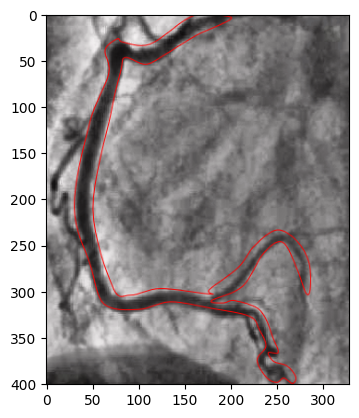

In [66]:
regions_img = cv2.cvtColor(
    cv2.imread('input/regions.png'),
    cv2.COLOR_RGB2BGR
)
plt.imshow(regions_img)

In [83]:
red = regions_img[:,:,0]
green = regions_img[:,:,1]
blue = regions_img[:,:,2]

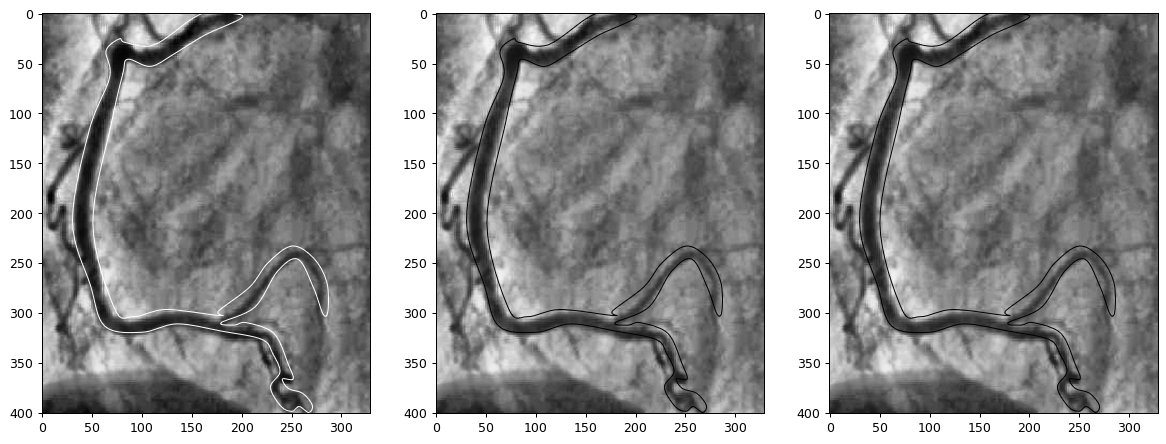

In [90]:
plt.figure(figsize=(16,9), dpi=90)
plt.subplot(1,3,1)
plt.imshow(red,'gray')
plt.subplot(1,3,2)
plt.imshow(green,'gray')
plt.subplot(1,3,3)
plt.imshow(blue,'gray')

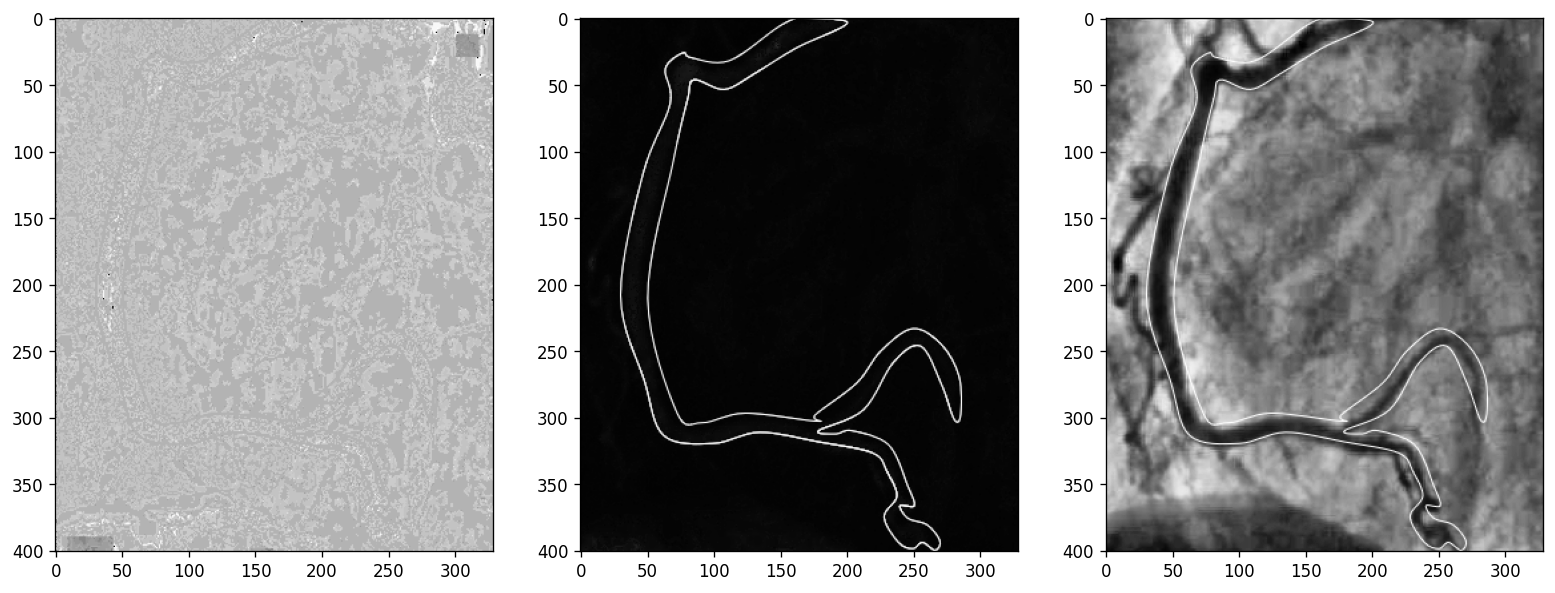

In [106]:
hsv = cv2.cvtColor(regions_img, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(16,9), dpi=120)
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(hsv[:,:,i], 'gray')

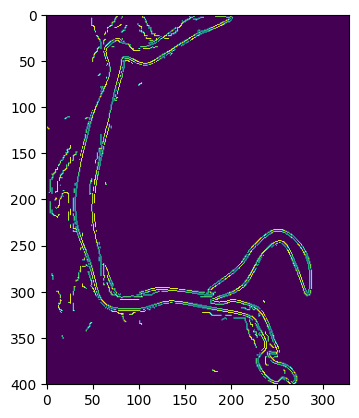

In [93]:
plt.imshow( cv2.Canny(red, 200, 250) )

In [78]:
ret, red = cv2.threshold(
    regions_img[:,:,0], 
    240,
    255,
    cv2.THRESH_BINARY
) 
print(f"len(red)={len(red)} type(red)={type(red)}")

len(red)=401 type(red)=<class 'numpy.ndarray'>


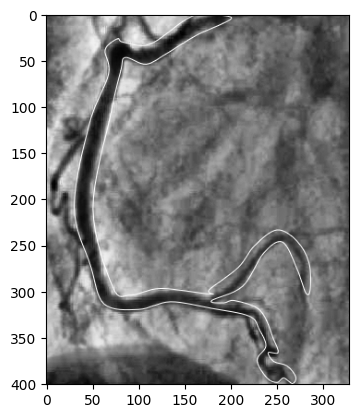

In [96]:
plt.imshow(red,'gray')

In [100]:
red8 = cv2.convertScaleAbs( regions_img[:,:,0] )
print(f"len(red8)={len(red8)} type(red8)={type(red8)} red8.shape={red8.shape} red8.dtype={red8.dtype}")

len(red8)=401 type(red8)=<class 'numpy.ndarray'> red8.shape=(401, 329) red8.dtype=uint8


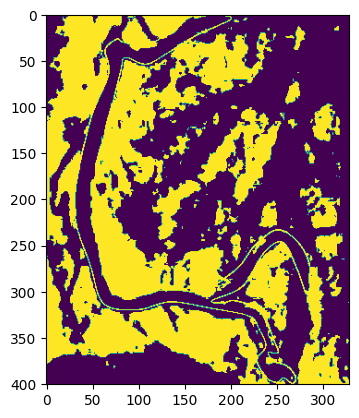

In [102]:
otsu_threshold, image_result = cv2.threshold(
    red8,
    0, 
    255, 
    cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)
plt.imshow(image_result)

In [34]:

showImage('red',red)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numerical tuple
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'
